<a href="https://colab.research.google.com/github/rizukiii12/sentiment-analysis/blob/main/kondingan_sentimen_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score




In [3]:
# Memuat data
file_path = 'all-eyes-on-rafah.csv'
try:
    data = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding='latin1')

# Melihat informasi umum tentang data
data.info()

# Melihat beberapa baris pertama dari data
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1188 non-null   object
dtypes: object(1)
memory usage: 9.4+ KB


,text
0,Pernah ga sih lo online X jam 3 pagi cuma buat...
1,Selamat kepada pemenang Modal receh JP gede......
2,bank Weh plis make over itu juga bagus bgt ges...
3,posting all eyes on rafah di ig story lu ga gu...
4,All Eyes on rafah


In [4]:
# Download resource yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Inisialisasi lemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Fungsi pre-processing teks
def preprocess_text(text):
    # Tokenisasi
    words = word_tokenize(text)

    # Konversi ke lower case dan lemmatization
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum()]

    # Menghapus stopwords
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

# Menerapkan pre-processing ke kolom teks
data['clean_text'] = data['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download resource yang diperlukan
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [6]:
# Inisialisasi VADER
sid = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan skor sentimen
def get_sentiment_scores(text):
    return sid.polarity_scores(text)

# Menerapkan fungsi ke teks yang telah diproses
data['sentiment_scores'] = data['clean_text'].apply(get_sentiment_scores)

# Memisahkan skor sentimen menjadi kolom-kolom terpisah
sentiment_df = pd.json_normalize(data['sentiment_scores'])

# Menggabungkan dengan dataframe utama
data = pd.concat([data, sentiment_df], axis=1)

# Menambahkan kolom label sentimen
data['sentiment'] = data.apply(lambda row: 'positive' if 'all eyes on rafah' in row['text'].lower() else ('positive' if row['compound'] >= 0 else 'negative'), axis=1)

# Menampilkan hasil pelabelan
data[['text', 'clean_text', 'sentiment']].head()


,text,clean_text,sentiment
0,Pernah ga sih lo online X jam 3 pagi cuma buat...,pernah ga sih lo online x jam 3 pagi cuma buat...,positive
1,Selamat kepada pemenang Modal receh JP gede......,selamat kepada pemenang modal receh jp gede me...,positive
2,bank Weh plis make over itu juga bagus bgt ges...,bank weh plis make itu juga bagus bgt ge kalo ...,positive
3,posting all eyes on rafah di ig story lu ga gu...,posting eye rafah di ig story lu ga guna bang ...,positive
4,All Eyes on rafah,eye rafah,positive


In [7]:
# Memisahkan fitur dan label
X = data['clean_text']
y = data['sentiment']

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mengubah teks menjadi fitur numerik dengan CountVectorizer
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Inisialisasi dan pelatihan model Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vect, y_train)

# Memprediksi set pengujian
y_pred = nb_model.predict(X_test_vect)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

    positive       1.00      1.00      1.00       238

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted avg       1.00      1.00      1.00       238



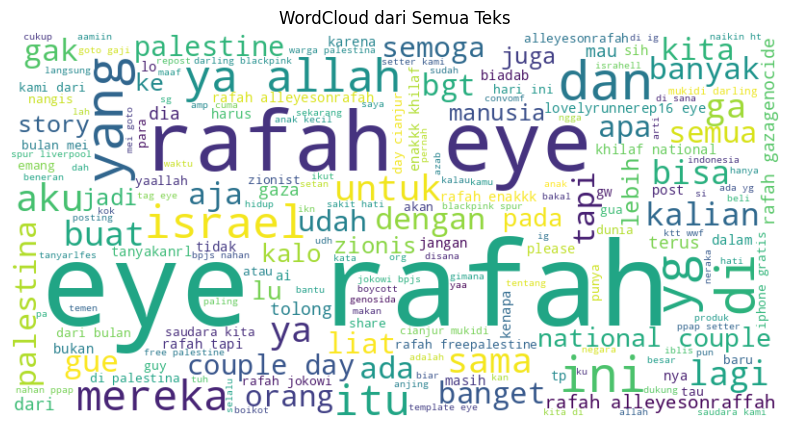

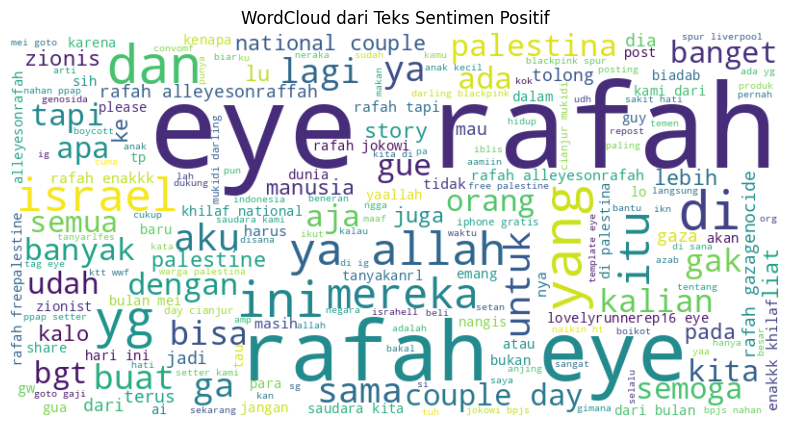

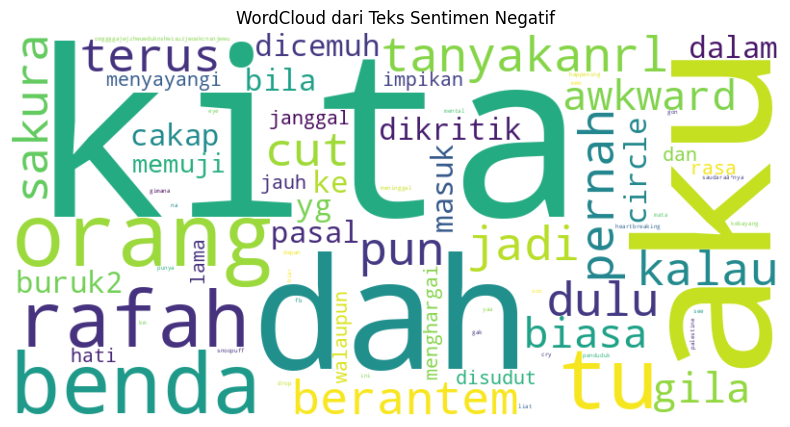

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan semua teks menjadi satu string untuk WordCloud
all_text = ' '.join(data['clean_text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dari Semua Teks')
plt.show()

# Teks untuk sentimen positif dan negatif
positive_text = ' '.join(data[data['sentiment'] == 'positive']['clean_text'])
negative_text = ' '.join(data[data['sentiment'] == 'negative']['clean_text'])

# WordCloud untuk sentimen positif
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dari Teks Sentimen Positif')
plt.show()

# WordCloud untuk sentimen negatif
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dari Teks Sentimen Negatif')
plt.show()


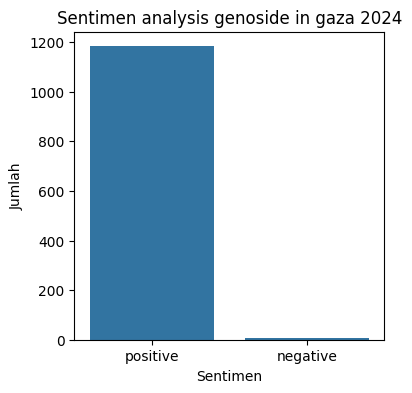

In [12]:
import seaborn as sns

# Visualisasi distribusi sentimen
plt.figure(figsize=(4, 4))
sns.countplot(x='sentiment', data=data, order=['positive', 'negative'])
plt.title('Sentimen analysis genoside in gaza 2024')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()
